# Clasificación de usos de suelo para Petorca.


**Créditos**: Este Notebook se basa en la serie [Land Use and Land Cover (LULC) Mapping Tutorial](https://colab.research.google.com/drive/1Wj0LsIuotZssoQUw0QUryWk9WbOFIzV8?usp=sharing) de los autores Ankur Mahesh e Isabelle Tingzon.


## 0.Importación de Librerías y funciones.

In [15]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 35.9 MB/s eta 0:00:00


In [1]:
!pip -q install eeconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.2 MB/s eta 0:00:00


In [18]:
# Standard imports
from tqdm.notebook import tqdm
import json

import pandas as pd
import numpy as np
from PIL import Image

import warnings
warnings. filterwarnings('ignore')

# Geospatial processing packages
import geopandas as gpd
#import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import ee
import eeconvert as eec
import geemap
#import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

### En Colab: Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [6]:
path='drive/MyDrive/Colab Notebooks/'

### Authentificación en Google Earth Engine

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-aguirrepaula')

KeyboardInterrupt: 

## 1. Zona de estudio: Petorca


In [21]:
# Read data using GeoPandas
zones= gpd.read_file('%sdataton_zonas.gpkg'%path)
petorca=zones[zones['zona']=='petorca']

In [20]:

x=petorca.to_crs(4326).geometry[0].geoms[0].exterior.coords.xy[0]
y=petorca.to_crs(4326).geometry[0].geoms[0].exterior.coords.xy[1]
xy=[]
for xi,yi in zip(x,y):
    xy.append([xi,yi])
aoi = ee.Geometry.Polygon(xy)

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

## 2. Generar imágenes Sentinel 2 y grilla de tiles para la zona de estudio.


### 2.1 Seleccionar y visualizar una imagen de S2.

In [104]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000,

    )
    task.start()

    return task

In [105]:
# LULC Classes
classes = ['built','crop','grass','water']

def generate_image(region,product='COPERNICUS/S2_SR',min_date='2023-11-01',max_date='2024-04-01',range_min=0,range_max=2000,cloud_pct=10):

    # Generate median aggregated composite
    image = ee.ImageCollection(product).filterBounds(region).filterDate(str(min_date), str(max_date)).filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct)).median()

    return image.clip(region)

In [156]:
# Get the shape geometry
centroid = petorca.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(petorca) #geodataframe to feature collection

yr=2021
myImage = generate_image(aoi,product='COPERNICUS/S2_SR',min_date='%s-11-01'%yr, max_date='%s-12-31'%yr,cloud_pct=10).select(['B4','B3','B2'])

range_min=0
range_max=4000
im_tif= myImage.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
filename='Petorga_rgb_%s'%yr
print(filename)
folder='Colab Notebooks'
task = export_image(im_tif, filename, region, folder)

Petorga_rgb_2021
Exporting to Petorga_rgb_2021.tif ...


In [157]:
task.status()

{'state': 'COMPLETED',
 'description': 'Petorga_rgb_2021',
 'priority': 100,
 'creation_timestamp_ms': 1712418111197,
 'update_timestamp_ms': 1712418234967,
 'start_timestamp_ms': 1712418116401,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1rEnNdmYyqsg-7jG7sqcjeWH3JQ_w5rff'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 50.14390563964844,
 'id': 'J2AQHXRFRM53AA7FVI2NXPQT',
 'name': 'projects/ee-aguirrepaula/operations/J2AQHXRFRM53AA7FVI2NXPQT'}

#### Visualización de la imagen.

In [155]:
# Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
vis_params = {"min": range_min, "max": range_max, "bands": ["B4", "B3", "B2"]}
Map.addLayer(myImage, vis_params,name='S2')
Map.addLayer(im_tif,name='S2_tif')
Map.addLayerControl()
Map

Map(center=[-32.245030815515236, -70.94275145594118], controls=(WidgetControl(options=['position', 'transparen…

### 2.2 Generar grilla de tiles en formato GeoJSON.

Se divide la zona de estudio en tiles de 64x64 pixeles, siguiendo la estructura de las imágenes de entrenamiento del **EuroSAT RGB dataset**. Se puede usar otro tamaño.

In [13]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [163]:
output_file = '%stilesPetorca.geojson'%path

tif_name='%s/Petorca_rgb_2023'%path
tif_file=tif_name+'.tif'

tile_size=64 #pixeles
tiles = generate_tiles(tif_file, output_file, 'Petorca', size=tile_size)
print('Data dimensions: {}'.format(tiles.shape))
tiles_aoi=gpd.sjoin(tiles,petorca,how='inner',predicate='within')


  0%|          | 0/6566616 [00:00<?, ?it/s]

Data dimensions: (1634, 2)


In [164]:
tiles_aoi

,id,geometry,index_right,zona
51,petorca-51,"POLYGON ((-71.00401 -32.13570, -71.00401 -32.1...",0,petorca
52,petorca-52,"POLYGON ((-70.99826 -32.13570, -70.99826 -32.1...",0,petorca
53,petorca-53,"POLYGON ((-70.99251 -32.13570, -70.99251 -32.1...",0,petorca
54,petorca-54,"POLYGON ((-70.98676 -32.13570, -70.98676 -32.1...",0,petorca
94,petorca-94,"POLYGON ((-71.00401 -32.14145, -71.00401 -32.1...",0,petorca
...,...,...,...,...
1525,petorca-1525,"POLYGON ((-70.93502 -32.33118, -70.93502 -32.3...",0,petorca
1541,petorca-1541,"POLYGON ((-70.84303 -32.33118, -70.84303 -32.3...",0,petorca
1566,petorca-1566,"POLYGON ((-70.94652 -32.33692, -70.94652 -32.3...",0,petorca
1567,petorca-1567,"POLYGON ((-70.94077 -32.33692, -70.94077 -32.3...",0,petorca


### Visualizar tiles.

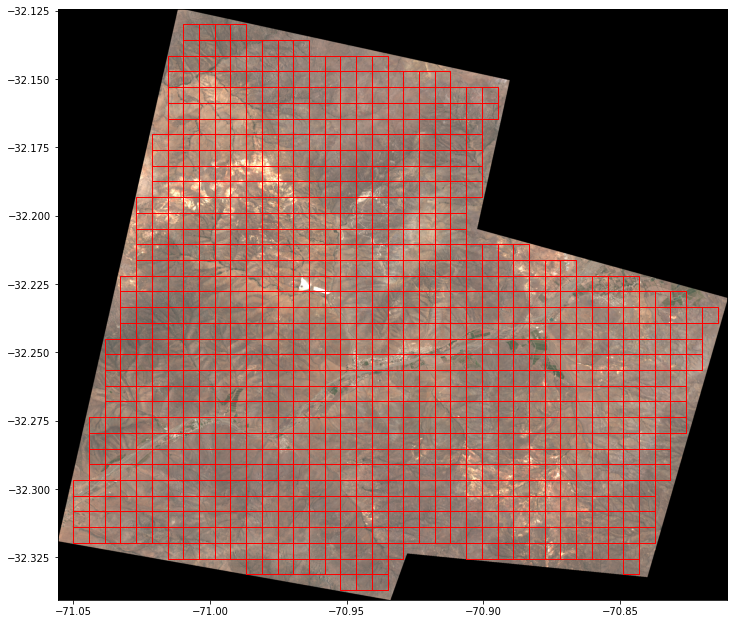

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
tiles_aoi.plot(facecolor="none", edgecolor='red', ax=ax)
show(rio.open(tif_file), ax=ax);

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape
  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

# 3.Generar Clasificación de Uso de Suelo.

In [7]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## 3.1 Cargar modelo entrenado sobre EuroSAT.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = '%s/models/best_model.pth'%path

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


Model file drive/MyDrive/Colab Notebooks//models/best_model.pth successfully loaded.


Remember in the previous tutorial that we applied a set of data transformations to our test set. Before we run our new images through the model, we'll need to apply these same transformation to our new data as follow.

In [9]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## 3.2 Predicción

In [12]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'drive/MyDrive/Colab Notebooks/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        try:
          label = str(classes[int(pred[0])])
        except:
          label = str(-1)

        if show:
          out_image.show(title=label)

        return label

    return None

Let's iterate over every 64x64 px tile and generate model predictions for the corresponding cropped image. Note that we are overwriting each temporary TIFF file to save storage space.

You can also download the resulting [model predictions here](https://drive.google.com/file/d/1-1ta68g8aBEqpVR2G5fXPnm23m10UyAu/view?usp=sharing). Make sure to save it in `"./drive/My Drive/Colab Notebooks/Kreis Borken_preds.geojson. `

In [79]:
output_file = '%stilesPetorca.geojson'%path

tif_name='%s/Petorca_rgb_2023'%path
tif_file=tif_name+'.tif'

tile_size=64 #pixeles
tiles = generate_tiles(tif_file, output_file, 'Petorca', size=tile_size)
print('Data dimensions: {}'.format(tiles.shape))
tiles_aoi=gpd.sjoin(tiles,petorca,how='inner',predicate='within')

In [ ]:
tile_size=64 #pixeles

# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]


for yr in np.arange(2020,2023,1):

  print('Predict %d'%yr)
  print('Create tile')
  #Create tiles
  output_file = '%stilesPetorca_%d.geojson'%(path,yr)

  tif_name='%s/Petorga_rgb_%d'%(path,yr)
  tif_file=tif_name+'.tif'
  print(tif_file)

  tiles = generate_tiles(tif_file, output_file, 'Petorca', size=tile_size)
  print('Data dimensions: {}'.format(tiles.shape))
  tiles_aoi=gpd.sjoin(tiles,petorca,how='inner',predicate='within')

  # Commence model prediction
  labels = [] # Store predictions
  for index in tqdm(range(len(tiles_aoi)), total=len(tiles_aoi)):
    label = predict_crop(tif_file, [tiles_aoi.iloc[index]['geometry']], classes, model)
    labels.append(label)

  tiles_aoi['pred_%d'%yr] = labels

  # Cleanup temporary files
  !rm 'drive/MyDrive/Colab Notebooks/temp.tif'

  print(tif_file)
  # Save predictions
  filepath = path + "tiles_preds_S2_%d.geojson"%yr
  tiles_aoi.to_file(filepath, driver="GeoJSON")



Predict 2020
Create tile
drive/MyDrive/Colab Notebooks//Petorga_rgb_2020.tif


  0%|          | 0/6566616 [00:00<?, ?it/s]

Data dimensions: (1634, 2)


  0%|          | 0/973 [00:00<?, ?it/s]

## 3.2 Visualizar  Mapa Interactivo


In [82]:
filepath = path + "tiles_preds.geojson"
tiles = gpd.read_file(filepath)
tiles.head(3)

,id,index_right,zona,pred,geometry
0,petorca-51,0,petorca,HerbaceousVegetation,"POLYGON ((-71.00401 -32.13570, -71.00401 -32.1..."
1,petorca-52,0,petorca,HerbaceousVegetation,"POLYGON ((-70.99826 -32.13570, -70.99826 -32.1..."
2,petorca-53,0,petorca,HerbaceousVegetation,"POLYGON ((-70.99251 -32.13570, -70.99251 -32.1..."


In [85]:
# We map each class to a corresponding color
colors = {
  'AnnualCrop' : 'green',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellow',
  'Highway' : 'gray',
  'Industrial' : 'black',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'orange',
  'Residential' : 'red',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

,id,index_right,zona,pred,geometry,color
0,petorca-51,0,petorca,HerbaceousVegetation,"POLYGON ((-71.00401 -32.13570, -71.00401 -32.1...",#ffff00
1,petorca-52,0,petorca,HerbaceousVegetation,"POLYGON ((-70.99826 -32.13570, -70.99826 -32.1...",#ffff00


In [86]:
# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map